# ETHEREUM PRICE PREDICTION

###### <font color='gray'>By: Jeonwook Kang</font>

# TABLE OF CONTENTS

<font size=3rem>

- **[INTRODUCTION](#INTRODUCTION)<br>**
- **[DATA PREPARATION](#DATA-PREPARATION)**<br>
- **[MODEL](#MODEL)**<br>
- **[CONCLUSION](#CONCLUSION)<br>**
</font>

---

# INTRODUCTION

## Overview

Cryptocurrency market has first emerged during the start of last decade and has evolved into a widely accepted asset class with a promising potential of becoming a hedge against the traditional fiat currency. Moreover, it is the driving force towards the next industrial revolution that will create the ubiquity of Web 3.0, metaverse, and smart contracts. These evolutionary trends will play a key role in decentralizing vast amounts of data ultimately protecting the privacy of individuals. 

Although cryptocurrency itself has a bad reputation while deemed as volatile and dangerous, it has been the single most highest returning investment asset in the past decade. After the Covid-19 pandemic, both corporate and individual investors faced the harsh reality of a fragile traditional market. As a result, many people and firms opened up to the posibility of crypto investments and ignited the influx of capital which raised the market caps to trillions of dollars.

## Business Understanding

Bitcoin and Ethereum are the two most widely traded crypto assets. Both assets mirrored each other during the bull and bear markets in the past. As a result, individual investors often consider the two as similar assets, yet there are some key differences to the functionality of each crypto asset. While Bitcoin’s main function includes storing of values through the blockchain technology, Ethereum’s main function includes an endorsement of smart contracts that provides the ecosystem for the development of other crypto currencies. This Ethereum’s huge upside potential interested many investors and now deviated from the it’s reputation as a cheaper bitcoin substitute. Similar to the Bitcoin price, the price of Ethereum is still extremely volatile and many investors wish to understand the trending price and its volatility. This project could give an insight into the price of Ethereum solely from the data perspective.

## Objectives

The goals of this project includes:

- Use time series analysis
- Understand the underlying trend of Ethereum price
- Use time series model to forecast future prices
- Use other deep learning algorithm to predict future prices
- Analyze the results

## Data

Binance is the largest cryptocurrency trading platform in the world. Therefore both daily and hourly Ethereum trading records of Binance were downloaded from https://www.cryptodatadownload.com/data/binance/.

---

# DATA-PREPARATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



import warnings
warnings.filterwarnings('ignore')

In [2]:
df_d = pd.read_csv('data/Binance_ETHUSDT_d.csv')
df_h = pd.read_csv('data/Binance_ETHUSDT_1h.csv')

In [3]:
df_d

,,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
1641859200000,2022-01-11 00:00:00,ETH/USDT,3082.87000000,3087.18000000,3069.86000000,3071.66000000,4390.26010000,13511012.71939600,6263
1641772800000,2022-01-10 00:00:00,ETH/USDT,3151.97000000,3185.00000000,2928.83000000,3082.68000000,529818.38660000,1616550523.09720100,935157
1641686400000,2022-01-09 00:00:00,ETH/USDT,3080.98000000,3211.72000000,3057.35000000,3151.97000000,275874.16430000,864505480.88173800,591523
1641600000000,2022-01-08 00:00:00,ETH/USDT,3198.68000000,3250.00000000,3000.00000000,3080.95000000,400692.10610000,1252795163.48626900,814600
...,...,...,...,...,...,...,...,...,...
1503273600.0,2017-08-21,ETH/USDT,299.1,346.52,294.6,323.29,5134.54,1661944.36,NaN
1503187200.0,2017-08-20,ETH/USDT,290.91,300.53,282.85,299.1,2469.49,730800.66,NaN
1503100800.0,2017-08-19,ETH/USDT,293.96,299.9,278,290.91,2140.08,618248.58,NaN
1503014400.0,2017-08-18,ETH/USDT,302,311.79,283.94,293.96,9392.79,2815460.24,NaN


## Data Cleaning

The raw csv files have all its data as an object form. As a result the time of each row has to be transformed into date time object and all the prices have to be transformed into float type. Below are two functions that will clean and transform the raw dataset into a dataframe that will be used for this time series analysis. Although the database had several features including the highs, lows, and volumes of Ethereum trade, only the closing price was considered for this analysis. 

*Please note that because daily and hourly dataset has different time indications, two separate functions had to be written.

In [4]:
#Function to transform daily ethereum data into a time series data frame with date time index
def to_datetime_day(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    df['date'] = df['date'].str[0:10]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace = True)
    
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [5]:
#Function to transform hourly ethereum data into a time series data frame with date time index
def to_datetime_hour(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    def datetime_func(x):
        if 'AM' in x:
            return pd.to_datetime(x[0:13]+':00:00 AM').strftime('%Y-%m-%d %H:%M:%S')
        elif 'PM' in x:
            return pd.to_datetime(x[0:13]+':00:00 PM').strftime('%Y-%m-%d %H:%M:%S')
        else:
            return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
    
    df['date'] = df['date'].apply(datetime_func)
    df.set_index('date', inplace = True)
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [6]:
to_datetime_day(df_d)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10,3151.97,3185.00,2928.83,3082.68,529818.3866
2022-01-09,3080.98,3211.72,3057.35,3151.97,275874.1643
2022-01-08,3198.68,3250.00,3000.00,3080.95,400692.1061
2022-01-07,3406.81,3416.76,3064.42,3199.24,669631.7262
2022-01-06,3539.82,3550.43,3300.00,3406.81,496745.7413
...,...,...,...,...,...
2017-08-21,299.10,346.52,294.60,323.29,5134.5400
2017-08-20,290.91,300.53,282.85,299.10,2469.4900
2017-08-19,293.96,299.90,278.00,290.91,2140.0800


In [7]:
to_datetime_hour(df_h)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10 23:00:00,3062.73,3088.01,3054.06,3082.68,9189.4677
2022-01-10 22:00:00,3074.65,3084.96,3056.33,3062.73,6294.9157
2022-01-10 21:00:00,3082.68,3096.15,3068.12,3074.65,13234.7443
2022-01-10 20:00:00,3029.75,3088.00,3019.17,3082.68,15604.1474
2022-01-10 19:00:00,3042.90,3056.28,3020.21,3029.75,10499.1698
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


## Exploratory Analysis

In this analysis, I will first decompose our data to identity its trend and seasonality. Then I will transform the data to remove those trends to get stationary data. I will use the Augmented Dickey-Fuller test to make sure the data is stationary. Finally I will be using Auto Correlation and Partial Auto Correlation to interpret the order of Autoregressive(AR) and Moving Average(MA) factors of the more complicated ARIMA model.

In [8]:
#Creating daily and weekly resampled target variable
target_day = df_d['close'].resample('D').mean()
target_week = df_d['close'].resample('W').mean()

### Trend Analysis

The most important aspect about time series analysis is to identify and remove trends and seasonality in order to achieve stationary data. The purpose of acquiring this stationary data is to identify some kind of underlying patterns to ultimately predict the future data. In this analysis, we will first decompose our data to identity its trend and seasonality.

In [9]:
#Function that decomposes the data and plots those decomposed dataset
def decomposition_plot(data):
    decomposition = seasonal_decompose(data)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(8,15))
    
    plt.subplot(411)
    plt.plot(data, label='Original', color='blue')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    
    plt.tight_layout()

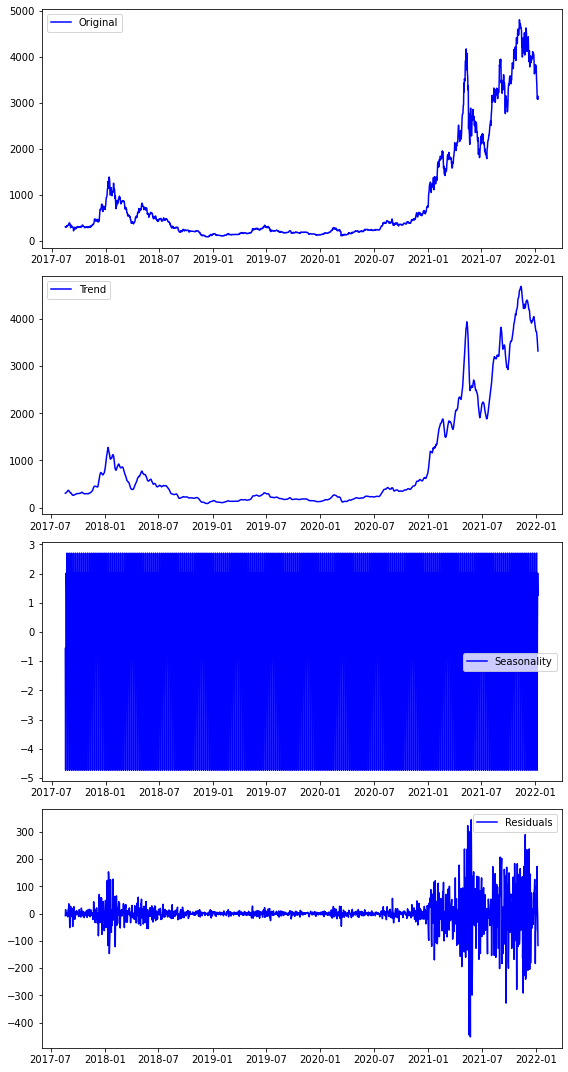

In [10]:
decomposition_plot(target_day)

**Note**
There are too many data points to interpret the seasonality. Residual plot is a plot with all the trends and seasonality removed, yet it still shows increasing variance. 
From this we can conclude two things: 
- log transforming our target(closing price) to reduce variance in the data
- performing the same analysis on weekly resampled data on its rolling mean.

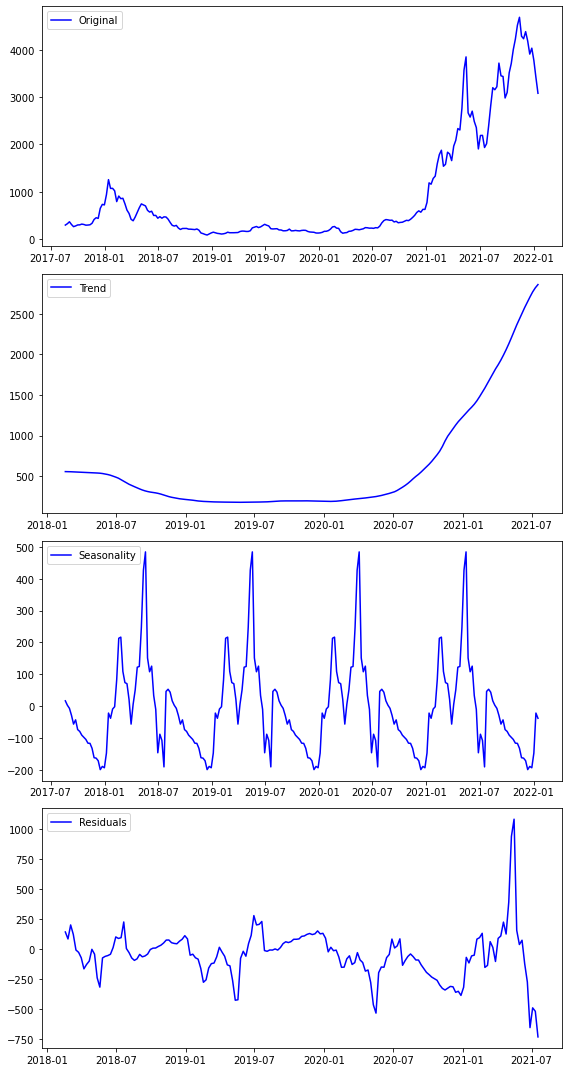

In [11]:
decomposition_plot(target_week)

**Here is a cleaner view of decomposition plots with Ethereum's weekly data.**

### Transfomation

There are several ways to transform existing data to a stationary data. The easiest method is to use decomposition tool to remove trend and seasonality to obtain residual data point. However, in our analysis we will perform log transformation to control variance. Then we will use Augmented Dickey-Fuller test results to confirm its stationarity.

#### Daily Target Data

In [12]:
#We log the close value to stabilize the variance in the data
target_day_log = np.log(target_day)

In [13]:
#Function that prints out he Augmented Dickey-Fuller test results.
def adfuller_score(df):
    dftest = adfuller(df)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
   
    print('Results of Dickey-Fuller Test: \n')
    print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                   -0.378676
p-value                           0.913599
#Lags Used                       10.000000
Number of Observations Used    1597.000000
Critical Value (1%)              -3.434451
Critical Value (5%)              -2.863352
Critical Value (10%)             -2.567734
dtype: float64


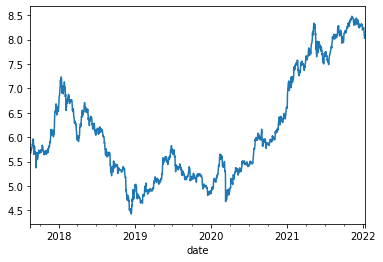

In [14]:
#Plotting the daily log value of closing price
target_day_log.plot();

#Printing the result of Dickey-Fuller test
adfuller_score(target_day_log)

**Note**
When we look at the p-value, we fail to reject the null hypothesis with an assumption that the data is not stationary. Therefore, we will take the difference of each value with a shift value of 1. Then we will perform the same test to check for stationarity.

Results of Dickey-Fuller Test: 

Test Statistic                -1.191146e+01
p-value                        5.284712e-22
#Lags Used                     9.000000e+00
Number of Observations Used    1.597000e+03
Critical Value (1%)           -3.434451e+00
Critical Value (5%)           -2.863352e+00
Critical Value (10%)          -2.567734e+00
dtype: float64


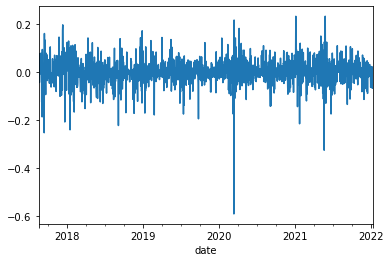

In [15]:
#Taking the difference of each day to its previous value
target_diff_day = target_day_log.diff(periods=1)
target_diff_day.dropna(inplace=True)

#Plotting the differenced data
target_diff_day.plot();

#Printing the result of Dickey-Fuller test
adfuller_score(target_diff_day)

**Note**
The p-value came out to be an extremely small number close to 0 so we can safely reject our null hypothesis and conclude our daily data is stationary. We can use this to plot Auto Correlation Function(ACF) and Partial Auto Correlation Function(PACF) which will be used later to explain the order of our AMRIMA model.

**REPEAT THE SAME STEP FOR WEEKLY RESAMPLED DATA**

#### Weekly Target Data

Results of Dickey-Fuller Test: 

Test Statistic                  -0.514152
p-value                          0.889225
#Lags Used                       1.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


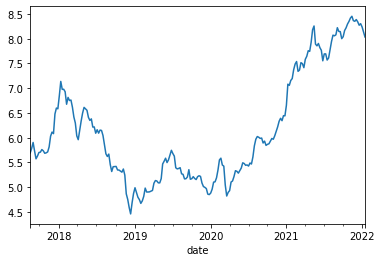

In [16]:
target_week_log = np.log(target_week)
target_week_log.plot();

adfuller_score(target_week_log)

Results of Dickey-Fuller Test: 

Test Statistic                -1.114260e+01
p-value                        3.081617e-20
#Lags Used                     0.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


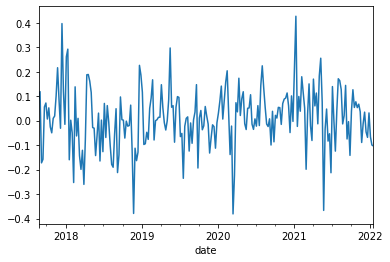

In [17]:
target_diff_week = target_week_log.diff(periods=1)
target_diff_week.dropna(inplace=True)

target_diff_week.plot();

adfuller_score(target_diff_week)

### AC/PAC Analysis

**In this daily target analysis, we can see that not much of current data can be explained through the correlation of lagged data. This indicates that time series model might not be the best prediction model for Ethereum price. Since there is no obvious indication of AC or PAC we will use grid search to obtain the best ARIMA model order.**

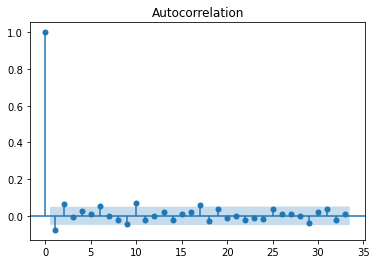

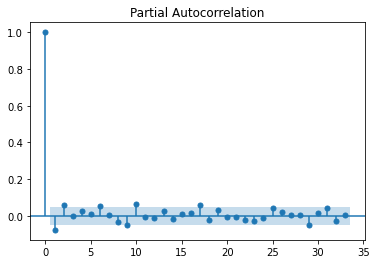

In [18]:
#Plotting ACF and PACF
plot_acf(target_diff_day);
plot_pacf(target_diff_day);

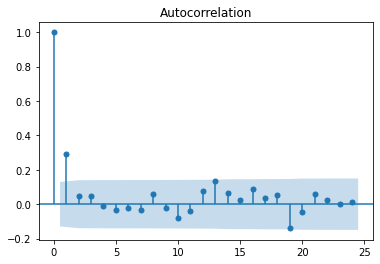

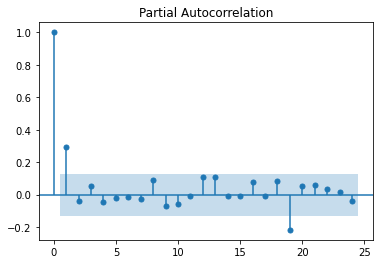

In [19]:
plot_acf(target_diff_week);
plot_pacf(target_diff_week);

**Note** 
There is a slight correlation between the current week's data and the past week's data. Therefore we will use grid search to investigate if first order Autoregressive and first order Moving Average model will best perform.

# MODEL

## ARIMA

In [20]:
#Function to split the data into training and test data
def train_test_split(data, ratio=0.82):
    train_size = int(len(data) * ratio)
    train, test = data[0:train_size], data[train_size:]
    return train, test

**Note**
The ratio of 82% training and 18% testing was deliberately used because later we will validate our model with 5 day forecast and 3 week forecast to calculate rmse each iteration of fitting the model and forecasting the next several predictions. With 18% of testing data both daily test data and weekly test data divides evenly into 5 and 3 respectively.

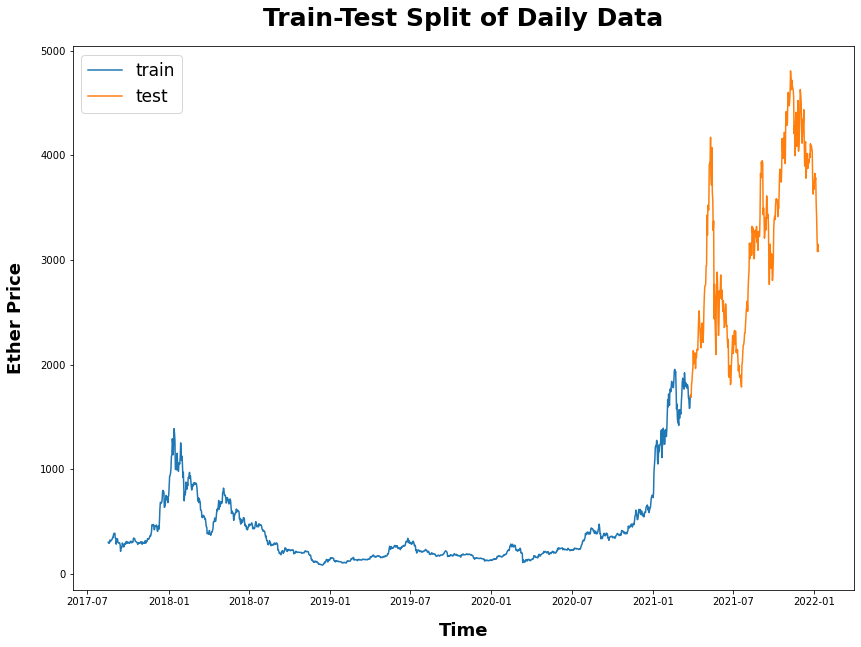

In [21]:
train_day, test_day = train_test_split(target_day)

#Plotting the split between training and test data of daily resampled dataset
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(train_day, label='train')
ax.plot(test_day, label='test')
ax.set_title('Train-Test Split of Daily Data', fontweight='bold', fontsize=25, pad=20);
ax.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax.set_ylabel('Ether Price', fontweight='bold', fontsize=18, labelpad=15)
plt.legend(loc=2,prop={'size': 17});

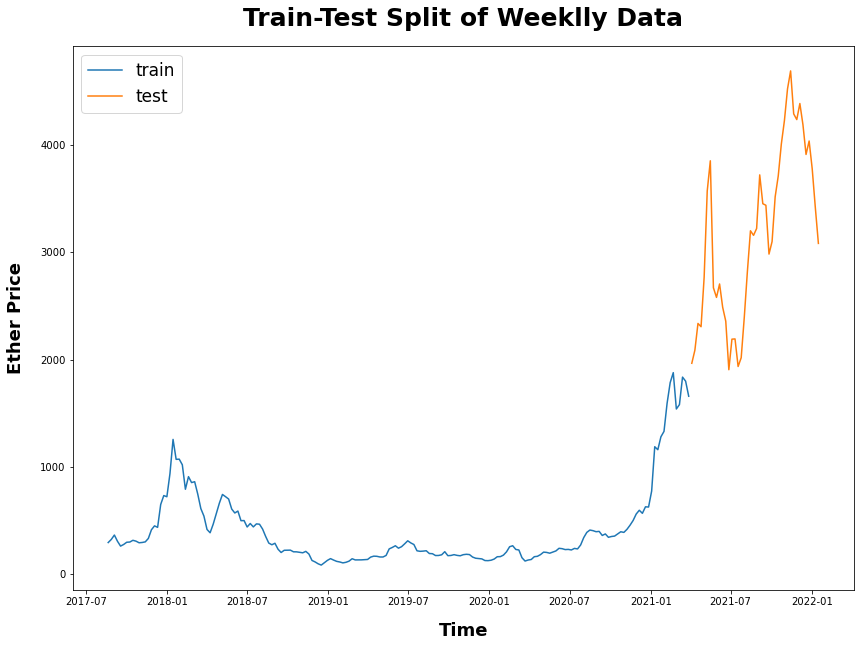

In [22]:
train_week, test_week = train_test_split(target_week)

#plotting train test for weekly data
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(train_week, label='train')
ax.plot(test_week, label='test')
ax.set_title('Train-Test Split of Weeklly Data', fontweight='bold', fontsize=25, pad=20);
ax.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax.set_ylabel('Ether Price', fontweight='bold', fontsize=18, labelpad=15)
plt.legend(loc=2,prop={'size': 17});

### Grid Search for ARIMA Order

In [23]:
#Function that iterates fitting of model to predict the price and calculate mean rmse of those 5 forecasts
#This is specifically for arima 5 day forecast into the future
def evaluate_arima_model_day(data, arima_order):

    train, test = train_test_split(data)
    history = [x for x in train]
    unlog_test = np.exp(test)
    predictions = list()
    error = list()
    for t in range(len(test))[::5]:
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=5)
        unlogged_yhat = np.exp(yhat)
        predictions += list(yhat)
        history += list(test.values[t:t+5])
        error.append(mean_squared_error(list(unlog_test.values[t:t+5]), unlogged_yhat))
    
    rmse = np.around(np.sqrt(error), 2) 
    rmse_mean = sum(rmse)/len(rmse)
    rmse_mean = np.around(rmse_mean, 2)
    return rmse_mean

**Note**
* The function above takes in the logged version of the data and returns the rmse of unlogged, actual price for better interpretability.
* The function below runs through the possibility of ARIMA order and returns the best performing order based on rmse.

In [24]:
#Function that chooses the best ARIMA order based on the rmse value for daily dataset
def evaluate_models_day(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float64')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model_day(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA{order} RMSE={rmse}'.format(order=order,rmse=rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.2f' % (best_cfg, best_score))

In [25]:
#Function that iterates fitting of model to predict the price and calculate mean rmse of those 3 week forecast
#This is specifically for arima 3 week forecast into the future
def evaluate_arima_model_week(data, arima_order):

    train, test = train_test_split(data)
    history = [x for x in train]
    unlog_test = np.exp(test)
    predictions = list()
    error = list()
    for t in range(len(test))[::3]:
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=3)
        unlogged_yhat = np.exp(yhat)
        predictions += list(yhat)
        history += list(test.values[t:t+3])
        error.append(mean_squared_error(list(unlog_test.values[t:t+3]), unlogged_yhat))
    
    rmse = np.around(np.sqrt(error), 2)
    rmse_mean = sum(rmse)/len(rmse)
    rmse_mean = np.around(rmse_mean, 2)
    return rmse_mean

In [26]:
#Function that chooses the best ARIMA order based on the rmse value for weekly dataset
def evaluate_models_week(dataset, p_values, d_values, q_values):
    #dataset = dataset.astype('float64')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model_week(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA{order} RMSE={rmse}'.format(order=order,rmse=rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.2f' % (best_cfg, best_score))

**Grid Search on daily dataset**

In [27]:
p_values = range(0, 4)
d_values = range(1, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models_day(target_day_log, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=226.76
ARIMA(0, 1, 1) RMSE=226.31
ARIMA(0, 1, 2) RMSE=225.93
ARIMA(0, 1, 3) RMSE=226.03
ARIMA(1, 1, 0) RMSE=226.23
ARIMA(1, 1, 1) RMSE=226.14
ARIMA(1, 1, 2) RMSE=225.95
ARIMA(1, 1, 3) RMSE=225.07
ARIMA(2, 1, 0) RMSE=225.91
ARIMA(2, 1, 1) RMSE=225.82
ARIMA(2, 1, 2) RMSE=226.94
ARIMA(2, 1, 3) RMSE=224.42
ARIMA(3, 1, 0) RMSE=225.84
ARIMA(3, 1, 1) RMSE=225.84
ARIMA(3, 1, 2) RMSE=224.82
ARIMA(3, 1, 3) RMSE=227.81
Best ARIMA(2, 1, 3) RMSE=224.42


**Note**
The best ARIMA model has second order auto regressive, first order differential, and third order moving average components. Auto regressive components are explained by the ACF while moving average is explained by PACF. The first order differential or integrated component just indicates that the model was run on difference of the price which makes sense by looking at the stationary graph. The graph became stationary only after it was differenced with shift of 1. Below also is the ARIMA order for weekly data. the only difference is that the auto regressive component came out to be third order meaning it is most likely explained by 3 shift dates of ACF.

**Grid Search on weekly dataset**

In [29]:
p_values = range(0, 4)
d_values = range(1, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models_week(target_week_log, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=479.01
ARIMA(0, 1, 1) RMSE=475.76
ARIMA(0, 1, 2) RMSE=480.84
ARIMA(0, 1, 3) RMSE=479.2
ARIMA(1, 1, 0) RMSE=482.63
ARIMA(1, 1, 1) RMSE=485.66
ARIMA(1, 1, 2) RMSE=482.41
ARIMA(1, 1, 3) RMSE=479.14
ARIMA(2, 1, 0) RMSE=484.98
ARIMA(2, 1, 1) RMSE=480.36
ARIMA(2, 1, 2) RMSE=479.17
ARIMA(2, 1, 3) RMSE=451.22
ARIMA(3, 1, 0) RMSE=478.89
ARIMA(3, 1, 1) RMSE=477.67
ARIMA(3, 1, 2) RMSE=480.31
ARIMA(3, 1, 3) RMSE=438.27
Best ARIMA(3, 1, 3) RMSE=438.27


### Model Forecast

**Forecasting daily resampled data**

In [30]:
#Function that takes in the data and order to return dataframe of 5 day prediction
def five_day_forecast(data, arima_order):

    train, test = train_test_split(data)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test))[::5]:
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=5)
        predictions += list(yhat)
        history += list(test.values[t:t+5])
    
    df_prediction = pd.DataFrame(predictions, index = test.index, columns = ['log_prediction'])
    df_prediction['prediction'] = np.exp(df_prediction['log_prediction'])
    return df_prediction

In [31]:
df_daily_prediction = five_day_forecast(target_day_log, (2,1,3))

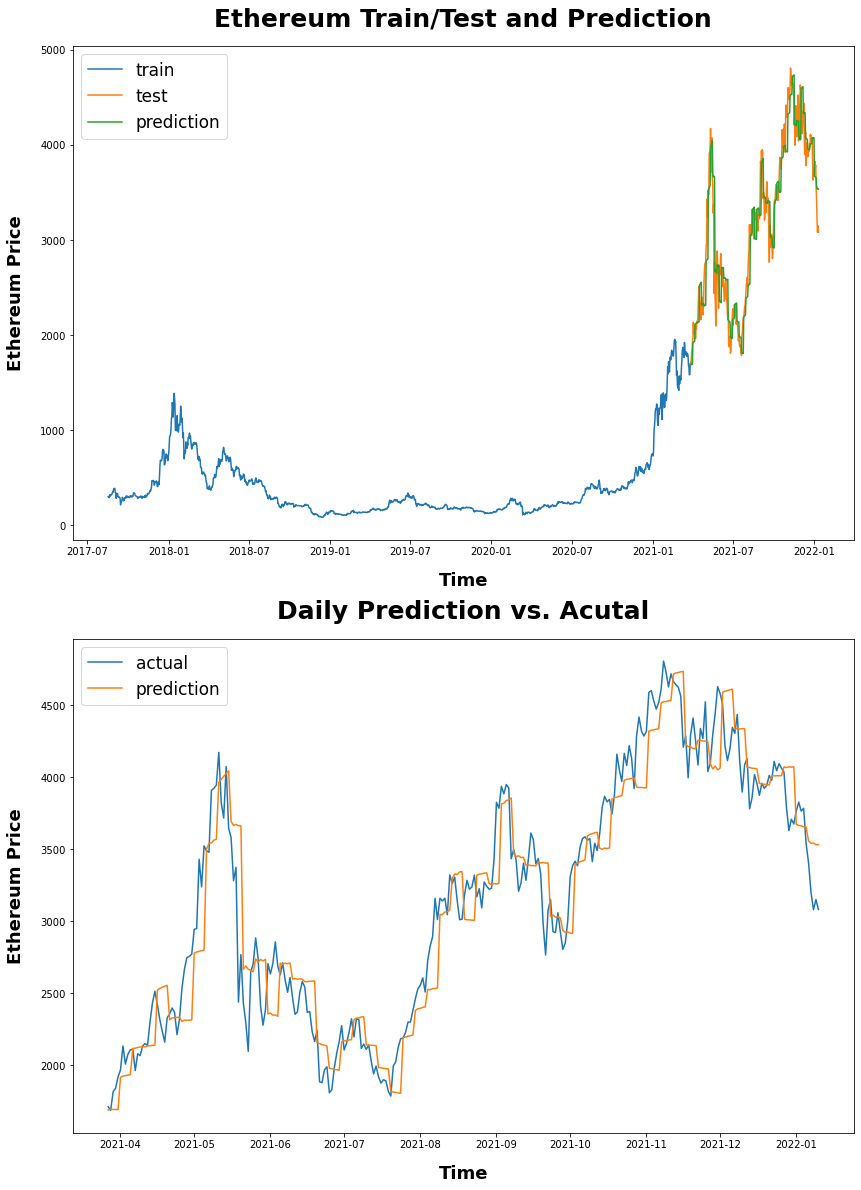

In [32]:
#Graphing the actual data points and the predictions
fig, (ax1, ax2) = plt.subplots(figsize=(14, 20), nrows=2)
ax1.plot(train_day, label='train')
ax1.plot(test_day, label='test')
ax1.plot(df_daily_prediction['prediction'], label='prediction')
ax1.set_title('Ethereum Train/Test and Prediction', fontweight='bold', fontsize=25, pad=20)
ax1.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax1.set_ylabel('Ethereum Price', fontweight='bold', fontsize=18, labelpad=15)
ax1.legend(loc=2,prop={'size': 17});

ax2.plot(test_day, label='actual')
ax2.plot(df_daily_prediction['prediction'], label = 'prediction')
ax2.set_title('Daily Prediction vs. Acutal', fontweight='bold', fontsize=25, pad=20)
ax2.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax2.set_ylabel('Ethereum Price', fontweight='bold', fontsize=18, labelpad=15)
ax2.legend(loc=2,prop={'size': 17});

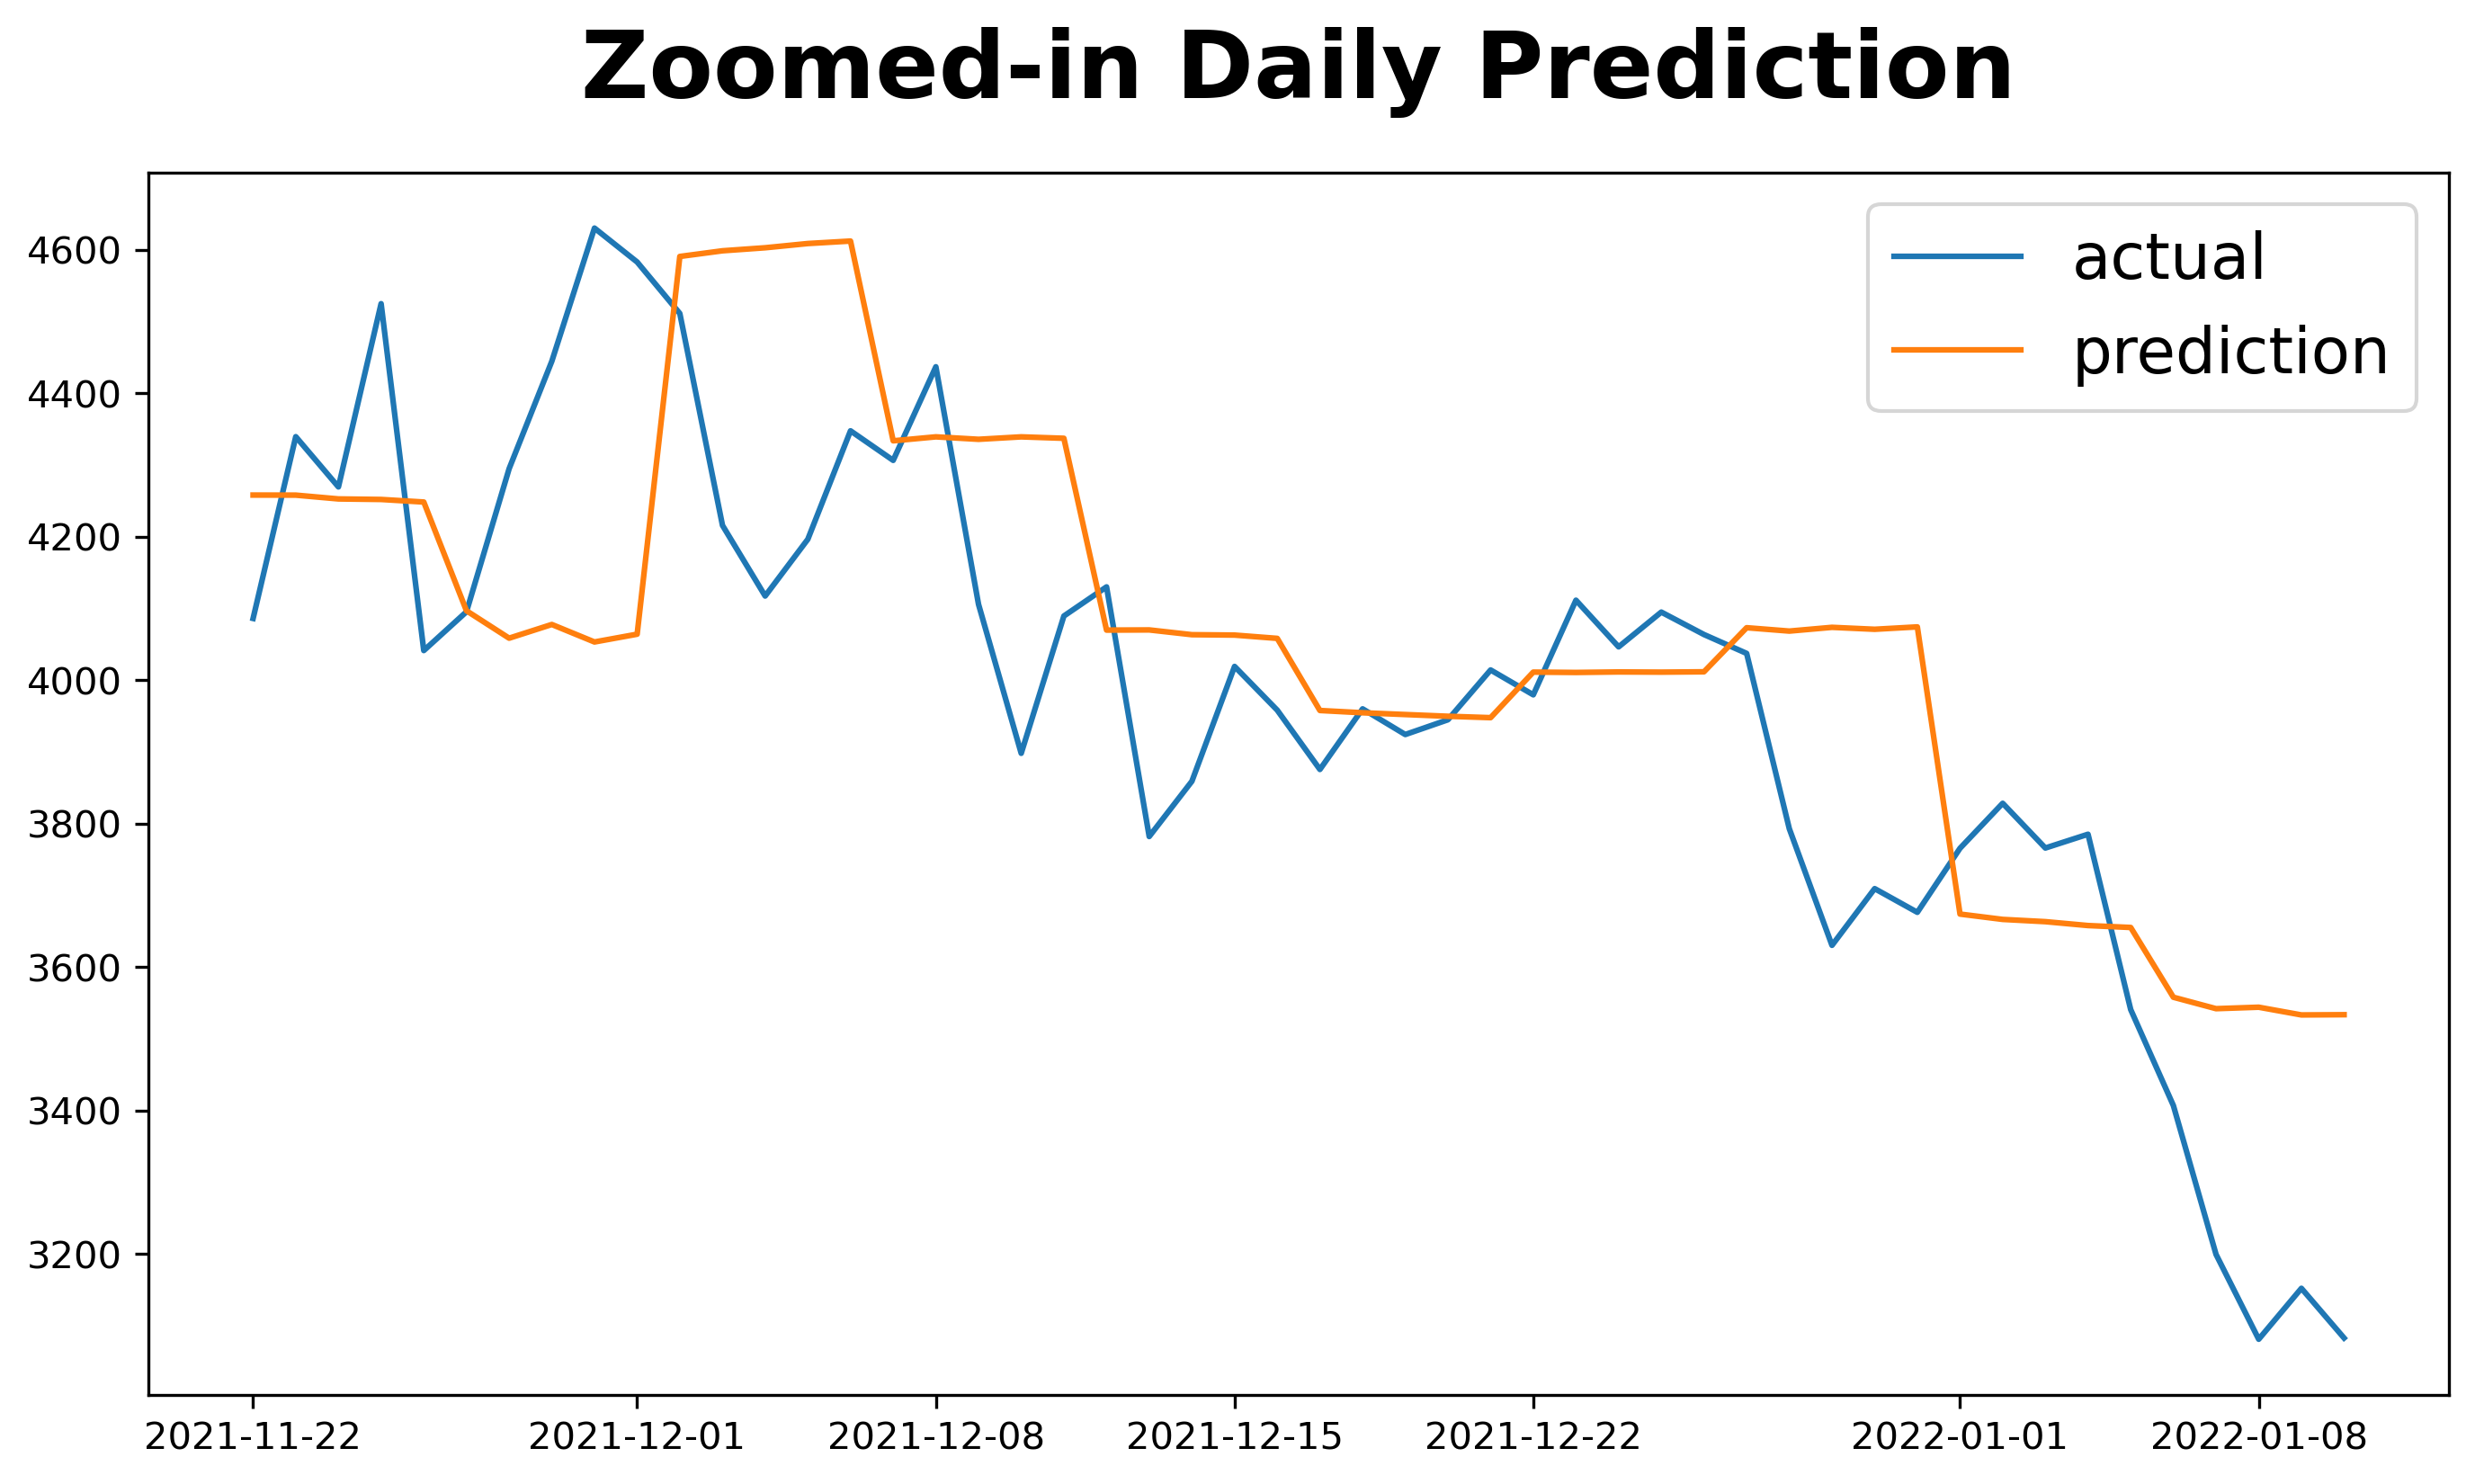

In [33]:
fig, ax = plt.subplots(figsize=(11,6), dpi=300)

ax.plot(test_day[-50:], label='actual')
ax.plot(df_daily_prediction['prediction'][-50:], label = 'prediction')
ax.set_title('Zoomed-in Daily Prediction', fontweight='bold', fontsize=25, pad=20)

ax.legend(loc=1,prop={'size': 17});

**Forecasting weekly resampled data**

In [34]:
def three_week_forecast(data, arima_order):

    train, test = train_test_split(data)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test))[::3]:
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=3)
        predictions += list(yhat)
        history += list(test.values[t:t+3])
    
    df_prediction = pd.DataFrame(predictions, index = test.index, columns = ['log_prediction'])
    df_prediction['prediction'] = np.exp(df_prediction['log_prediction'])
    return df_prediction

In [35]:
df_weekly_prediction = three_week_forecast(target_week_log, (3, 1, 3))

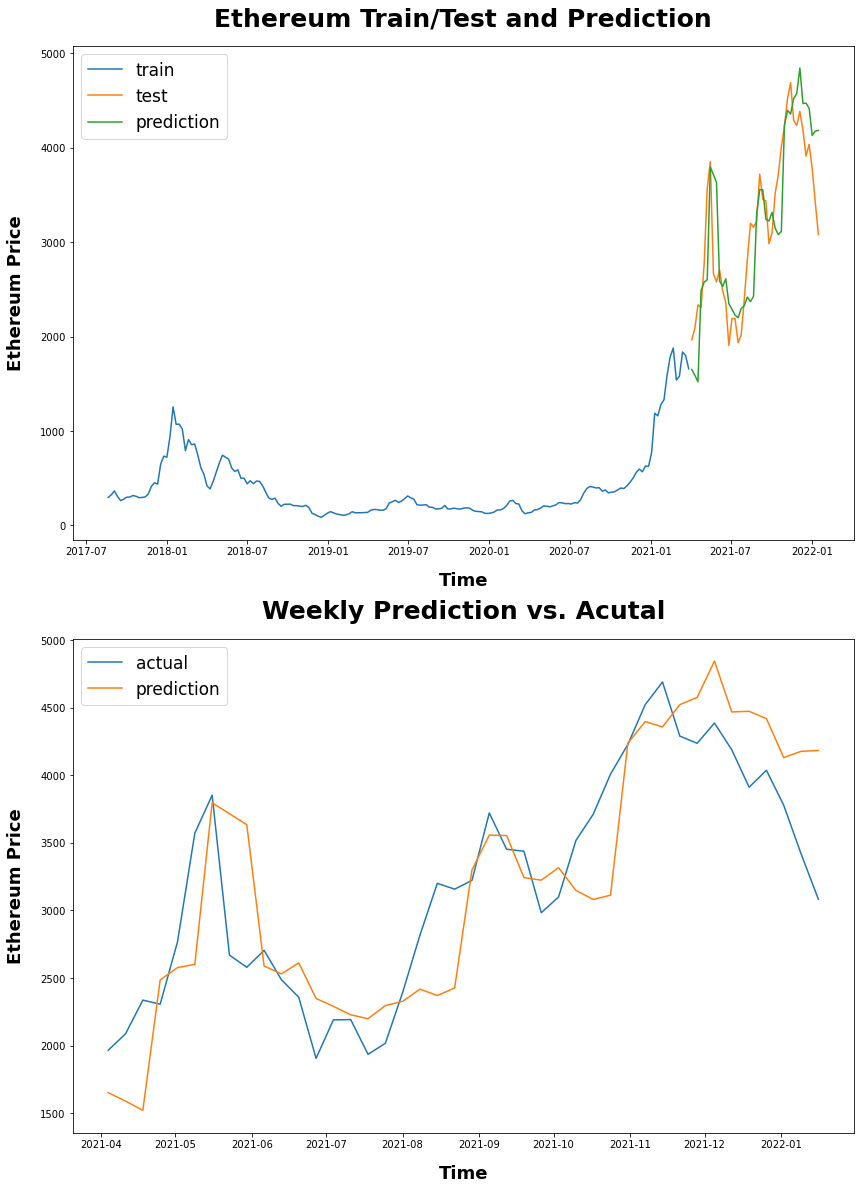

In [36]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 20), nrows=2)
ax1.plot(train_week, label='train')
ax1.plot(test_week, label='test')
ax1.plot(df_weekly_prediction['prediction'], label='prediction')
ax1.set_title('Ethereum Train/Test and Prediction', fontweight='bold', fontsize=25, pad=20)
ax1.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax1.set_ylabel('Ethereum Price', fontweight='bold', fontsize=18, labelpad=15)
ax1.legend(loc=2,prop={'size': 17});

ax2.plot(test_week, label='actual')
ax2.plot(df_weekly_prediction['prediction'], label = 'prediction')
ax2.set_title('Weekly Prediction vs. Acutal', fontweight='bold', fontsize=25, pad=20)
ax2.set_xlabel('Time', fontweight='bold', fontsize=18, labelpad=15)
ax2.set_ylabel('Ethereum Price', fontweight='bold', fontsize=18, labelpad=15)
ax2.legend(loc=2,prop={'size': 17});

## LSTM

#### Please reference LSTM notebook from Google Collab

# CONCLUSION

In Conclusion, it is almost impossible to accurately predict the exact price ahead of time as we are well aware that numerous factors have to be taken into account when trying to explain the dynamic market prices. In fact, all the analytic models are predicting prices from hindsight. However, these models do provide an insight to the general trend of market prices exclusively from the data perspective. As a result, for the improvement of this project, incorporating News keywords and trending tweets can help explain the variance and volatility of Ethereum and consequently it could produce a better performing model.